<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Todo" data-toc-modified-id="Todo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Todo</a></span></li><li><span><a href="#Some-notes" data-toc-modified-id="Some-notes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Some notes</a></span><ul class="toc-item"><li><span><a href="#Cost-functions" data-toc-modified-id="Cost-functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Cost functions</a></span></li></ul></li><li><span><a href="#Reg-alg" data-toc-modified-id="Reg-alg-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Reg alg</a></span><ul class="toc-item"><li><span><a href="#Viz-costs" data-toc-modified-id="Viz-costs-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Viz costs</a></span></li><li><span><a href="#Solving-just-one-instance-to-check-if-it-works-properly" data-toc-modified-id="Solving-just-one-instance-to-check-if-it-works-properly-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Solving just one instance to check if it works properly</a></span></li><li><span><a href="#Sampling-solutions" data-toc-modified-id="Sampling-solutions-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Sampling solutions</a></span></li><li><span><a href="#Run-complete-algorithm" data-toc-modified-id="Run-complete-algorithm-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Run complete algorithm</a></span></li></ul></li></ul></div>

In [1]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', size = 12)
rc('xtick', labelsize = 12)
rc('ytick', labelsize = 12)
rc('figure', figsize = (8, 4))

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from amod_ed.contractivity_v2 import viz_costs, _construct_problem
from amod_ed.contractivity_v2 import sample_solutions, run_algorithm
import cvxpy as cp
import networkx as nx

import pandas as pd

from amod_ed.contractivity_v2 import plot_results_run

# Description

This notebook lets us probe the different algorithms we talk about. 

# Todo


- implement the viz cost

# Some notes

## Cost functions

In the different functions of the code, the cost functions and inverse demand functions are defined based on BPR functions (out of simplicity). 

We take the following notation: 

$$
BPR(x,\kappa, \phi) = \phi(1+\alpha (x/\kappa)^\beta),
$$
where $\alpha$ and $\beta$ are parameters. 

The edge costs are actually BPR functions. As for the inverse demand functions, we define them as
$$
D^{-1} = - BPR() + S,
$$
where $S\in\mathbb{R}^+$ is the inverse demand shift, ensuring that $D^{-1}$ is larger than zero over a given subset of $\mathbb{R}^+$.

# Reg alg

Define a graph based on some parameters. As per the documentation, we have: 
- phi_p:
    list of floats, containing the value of phi for the passengers for each edge
- phi_inv:
    list of floats, containing the value of phi for the inverse demand functions
- k_p:
    list of floats, containing the value of kappa for each edge
- k_inv:
    list of floats, containing the value of kappa for the inverse demand edges
- shift_inv:
    list of floats, containing the value of the inverse demand shifts

In [3]:
edges = pd.read_excel('cost_edges.xlsx')

inv_edges = pd.read_excel('inv_demand.xlsx')

In [4]:
edges

,origin,destination,phi,k
0,1,2,1,3
1,1,2,2,3
2,2,1,1,3


In [5]:
inv_edges

,origin,destination,phi,k,shift
0,1,2,1,4,10
1,2,1,1,3,20


## Viz costs

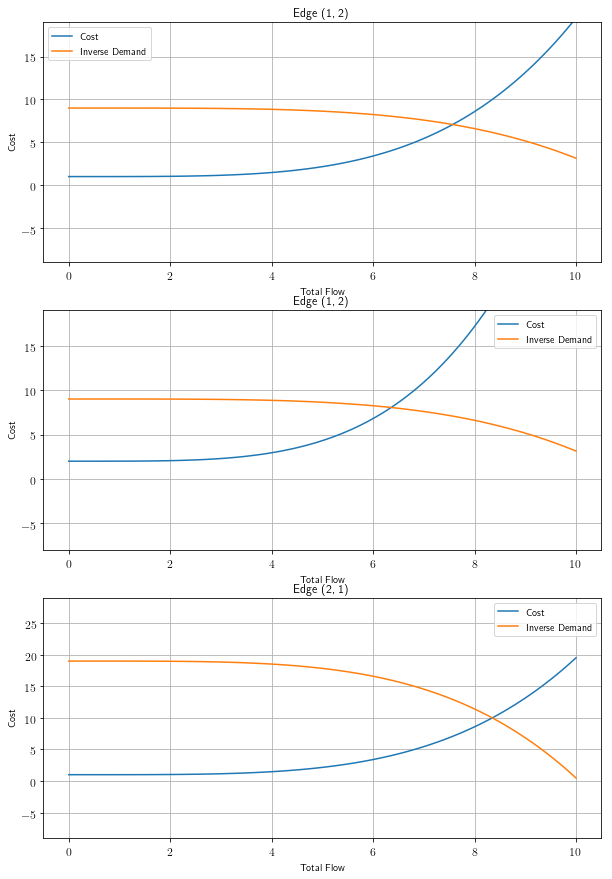

In [6]:
viz_costs(edges, inv_edges)

## Solving just one instance to check if it works properly

The below builds the optimization problem. 

In [176]:
f_p, f_r, r, prob, n_edges = _construct_problem(edges, inv_edges)

You can fix a value of the rebalancing guess (the parameter to this problem).

In [134]:
r_new = 0

In [144]:
r.value = r_new

You can then solve the problem. 

In [145]:
prob.solve(solver = cp.GUROBI)

-13.266478322978331

Check the status. 

In [146]:
prob.status

'optimal'

Check the values of the passenger and rebalancing flows. 

In [147]:
f_p.value

array([1.76172009, 0.14915721, 5.33532924])

In [148]:
f_r.value

array([3.05960439e+00, 1.65896964e-01, 8.36971126e-09])

Value of the new r

In [149]:
net_flow = [np.sum((n_edges == i)*f_p.value) for i in np.unique(n_edges)]

In [150]:
net_flow

[1.910877302145642, 5.335329235307474]

In [151]:
r_new = net_flow[0]-net_flow[1]

In [152]:
r_new

-3.4244519331618317

## Sampling solutions

Now you can sample initial points r_i and run one step of the iteration and compare the metrics. 

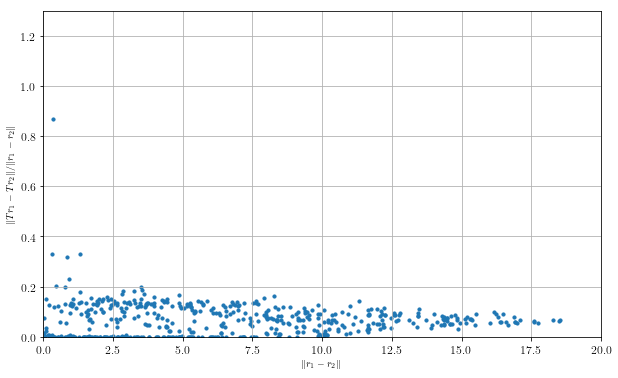

In [177]:
dT, dr = sample_solutions(edges, inv_edges, nsamples = 500, seed=0)

In [178]:
rat = np.divide(dT, dr)

In [179]:
np.max(rat)

0.8689092174426348

## Run complete algorithm

You can also run the complete algorithm for a given number of iterations. 

In [7]:
r_tot = run_algorithm(edges, inv_edges, nsolutions = 5, seed =0, max_iter = 15)

Academic license - for non-commercial use only


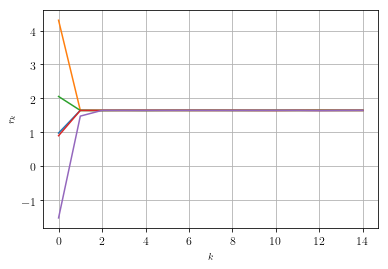

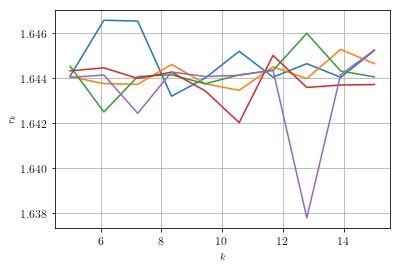

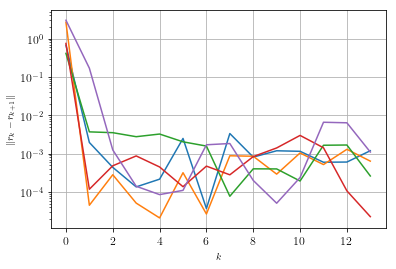

In [11]:
plot_results_run(r_tot)